# Using Homography to remove distortion from an image

This example will show how to:

- import images contianing ChAruCo boards
- Creating a ChAruCo board
- find aruco codes in those images
- refine the corners of those found codes
- If codes are found find charuco corners
- find a homography to go from one image to another
- Perform that homography transform to remove any perspective from an image

In [173]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

## Importing images

import from a directory, display the image

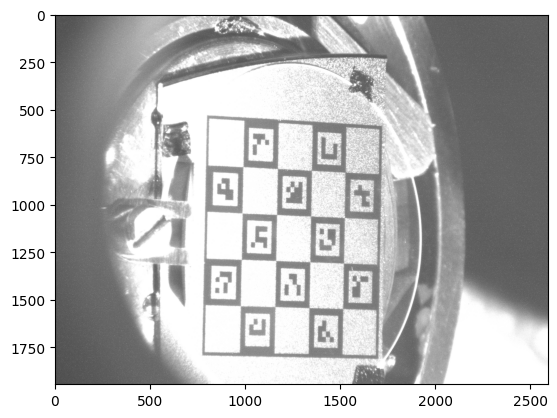

In [174]:
directory = "/home/emil/Apps/dev/aruco_dev/images/sissy1_screen/v1/"

filename = f"aruco_2_roi_full_bright_088.tiff"
#filename = f"aruco_2_full_bright_085.tiff"

#filename = f"aruco_2_zoomed_094.tiff"
#filename = f"aruco_2_zoomed_095.tiff"
#filename = "aruco_2_roi_058.tiff"
#filename = "aruco_2_zoomed_092.tiff"
#filename= "aruco_2_full_bright_083.tiff"

path = directory + filename

frame = cv2.imread(path)
plt.imshow(frame)
plt.ion()


## Creating ChArUco Boards



The board is 650 x 650 pixels or 16.25 x 16.25 mm


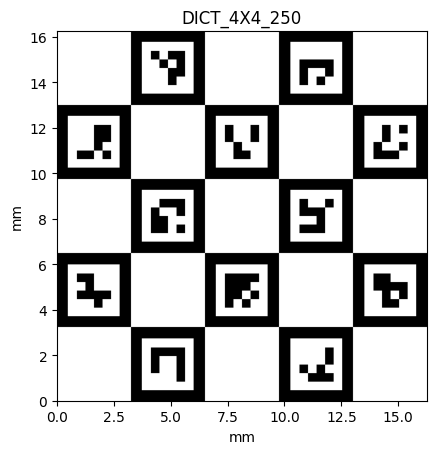

In [175]:

aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_250)

square_size = 20
marker_size = 14

# we are making a board to fit on a 2" disc
radius_um = 25000/2
um_pix = 25
radius = int(np.ceil(radius_um/um_pix))
bsize = int(radius*1.3)
board = cv2.aruco.CharucoBoard((5, 5,), square_size, marker_size, aruco_dict)
imboard = board.generateImage((bsize, bsize))

#We will invert our board because we are going to print it on a YAG:ce screen and want lots of white for looking at the beam
imboard = cv2.bitwise_not(imboard)

#for convienience we will write this to file
temp_board_filename = "tmp_imboard.png"
cv2.imwrite(directory+temp_board_filename,imboard)
imboard = cv2.imread(directory+temp_board_filename)
board_size_mm = bsize*um_pix/1000
plt.imshow(imboard,cmap="gray",extent=[0,board_size_mm,0,board_size_mm])
plt.xlabel("mm")
plt.ylabel("mm")
plt.title("DICT_4X4_250")


print(f"The board is {bsize} x {bsize} pixels or {board_size_mm} x {board_size_mm} mm")




## Detecting ArUco Markers

We have made a collection/ dictionary of markers that we can detect in images. We can use our original image as a test


In [176]:
parameters =  cv2.aruco.DetectorParameters()

#We previously inverted our board, so we need to make sure we can detect that as well
parameters.detectInvertedMarker=True

#We are dealing with quite low light images, so it will help us to increase the range of thresholds we attempt
parameters.adaptiveThreshWinSizeMax = 43

#We would like to use the points from our detection later for homography so we will take the extra processing for more precision
parameters.cornerRefinementMethod = cv2.aruco.CORNER_REFINE_SUBPIX

#We can define how precise we want to be
parameters.cornerRefinementMinAccuracy = 0.0001

Text(0.5, 1.0, 'Detected ArUco Markers')

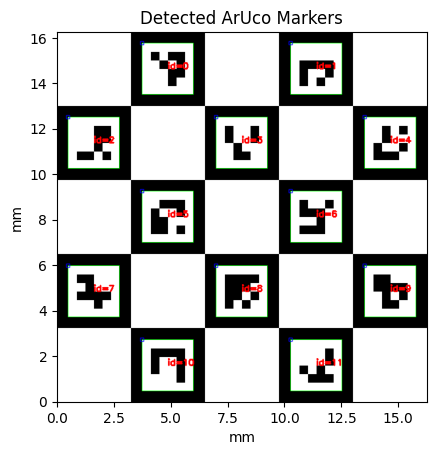

In [177]:
#Now let's detect the markers

def find_ArUco_refined(image,board, parameters):

    """
    Find aruco codes in an image and refine the points

    image: an image containing codes

    board: the ArUco board that is inside the image

    parameters: the detection parameters to use


    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    points,marker_ids,rejected_points = cv2.aruco.detectMarkers(gray,aruco_dict,parameters=parameters)
    cv2.aruco.refineDetectedMarkers(gray, board, points, marker_ids, rejected_points)

    return points, marker_ids, rejected_points

desired_total_points, desired_total_ids, rejects = find_ArUco_refined(imboard, board,parameters)
cv2.aruco.drawDetectedMarkers(imboard,desired_total_points,  desired_total_ids)

plt.imshow(imboard,extent=[0,board_size_mm,0,board_size_mm])
plt.xlabel("mm")
plt.ylabel("mm")
plt.title("Detected ArUco Markers")


## Find ChArUco Chessboard Corners

We are using a specific type of pattern. It contains more corners we can find


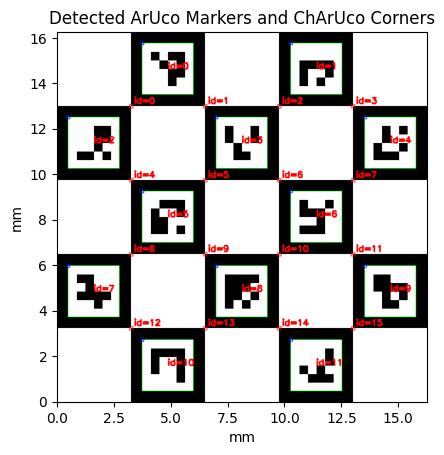

In [178]:
def find_ChArUco_refined(image,board, aruco_corners, aruco_ids):

    """
    Find aruco codes in an image and refine the points

    Then find 

    image: an image containing codes

    board: the ArUco board that is inside the image

    aruco_corners: A list of corners of previously found ArUco codes

    aruco_ids: A list of the id's of those corners


    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    num_charuco_corners, charuco_corners, charuco_ids = cv2.aruco.interpolateCornersCharuco(aruco_corners,aruco_ids,gray,board)

    return num_charuco_corners,charuco_corners, charuco_ids

num_charuco_corners,desired_total_charuco_corners, desired_total_charuco_ids = find_ChArUco_refined(imboard, board,desired_total_points,desired_total_ids)
if num_charuco_corners!=0:
    cv2.aruco.drawDetectedCornersCharuco(imboard, desired_total_charuco_corners, desired_total_charuco_ids)

    plt.imshow(imboard,extent=[0,board_size_mm,0,board_size_mm])
    plt.xlabel("mm")
    plt.ylabel("mm")
    plt.title("Detected ArUco Markers and ChArUco Corners")

else:
    print("No ChArUco corners detected")


## Now read from our file and do the same

- Open file
- Find Aruco
- If found find ChArUco corners



Text(0.5, 1.0, 'Detected ArUco Markers in aruco_2_full_bright_085.tiff')

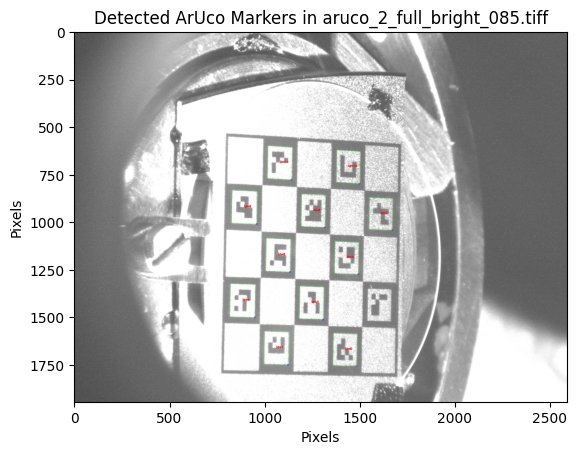

In [179]:
source_points, source_ids, rejects = find_ArUco_refined(frame, board,parameters)
cv2.aruco.drawDetectedMarkers(frame,source_points,  source_ids)

plt.imshow(frame)
plt.xlabel("Pixels")
plt.ylabel("Pixels")
plt.title(f"Detected ArUco Markers in {filename}")

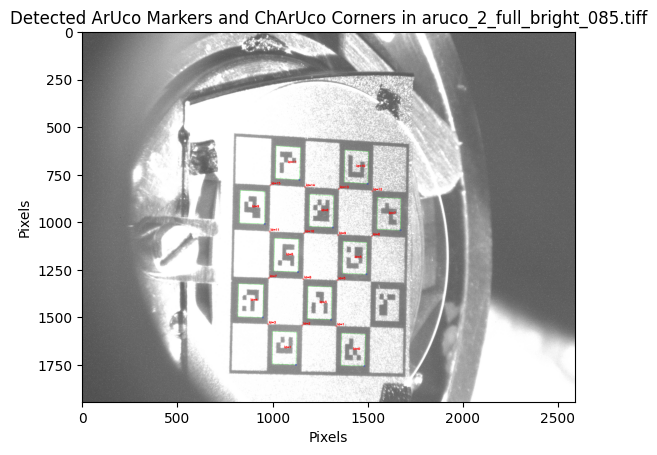

In [180]:
if len(source_ids)>0:
    num_charuco_corners, source_charuco_corners, source_charuco_ids = find_ChArUco_refined(frame, board,source_points,source_ids)
    cv2.aruco.drawDetectedCornersCharuco(frame, source_charuco_corners, source_charuco_ids)

    plt.imshow(frame)
    plt.xlabel("Pixels")
    plt.ylabel("Pixels")
    plt.title(f"Detected ArUco Markers and ChArUco Corners in {filename}")

    

## Now we want to find the common points in both images

First we'll find the common points in the ArUco sets, then the ChArUco corners

In [181]:
common_aruco_ids = np.intersect1d(source_ids,desired_total_ids)
print(f" The common aruco id's in the source and the desired board are {common_aruco_ids}") 



 The common aruco id's in the source and the desired board are [ 0  1  3  4  5  6  7  8  9 10 11]


In [182]:
# Determine the subset of points from the total possible ArUco points

def get_subset_from_ids(total_ids, sub_ids, total_points):

    """
    Given a list of ids, and another list of id's within that list, create a subset of the total points corresponding to this subset of common_ids

    total_ids: list
        the index of id's of the co-ords in total_points
    
    sub_ids: list
        the list of id's from the total_ids that we would like

    total_points: list of things

        the list of things that we want to make a subset of

    returns a list that is a subset of total_points and the indices of the items in the sub_ids list
    """

    ids_list = total_ids.tolist()
    indicies = []
    for id in sub_ids:
        indicies.append(ids_list.index(id))

    sub_points =  [total_points[i] for i in indicies]

    return sub_points

sub_desired_aruco_points = get_subset_from_ids(desired_total_ids, common_aruco_ids, desired_total_points)
sub_source_aruco_points = get_subset_from_ids(source_ids, common_aruco_ids, source_points)


Text(0.5, 1.0, 'The ArUco Markers in our source image')

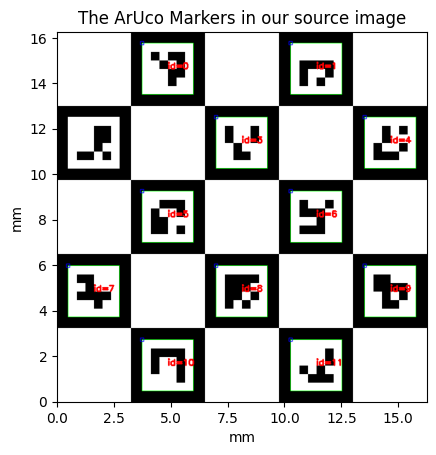

In [183]:
# Let's plot to check the points we are trying to get

imboard = cv2.imread(directory+temp_board_filename)
cv2.aruco.drawDetectedMarkers(imboard, sub_desired_aruco_points, np.array(common_aruco_ids))
plt.imshow(imboard,extent=[0,board_size_mm,0,board_size_mm])
plt.xlabel("mm")
plt.ylabel("mm")
plt.title("The ArUco Markers in our source image")

 The common charuco id's in the source and the desired board are [ 0  1  3  4  5  6  7  8  9 10 11]


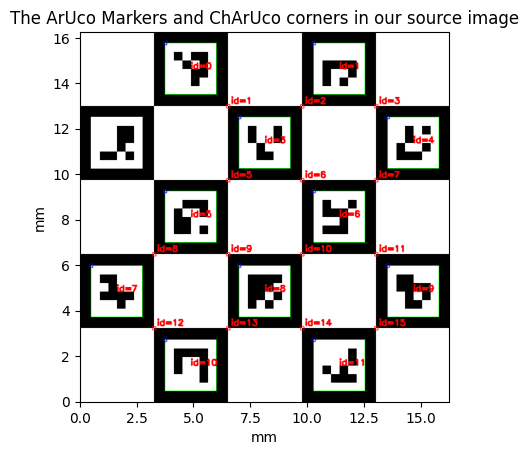

In [184]:
# If there are any chessboard corners in our source image, then let's take them as well

sub_source_charuco_points = []
sub_desired_charuco_points = []

if num_charuco_corners !=0:

    common_charuco_ids = np.intersect1d(source_charuco_ids,desired_total_charuco_ids)
    print(f" The common charuco id's in the source and the desired board are {common_aruco_ids}") 

    sub_desired_charuco_points = get_subset_from_ids(desired_total_charuco_ids, common_charuco_ids, desired_total_charuco_corners)
    sub_source_charuco_points = get_subset_from_ids(source_charuco_ids, common_charuco_ids, source_charuco_corners)

    cv2.aruco.drawDetectedCornersCharuco(imboard, np.array(sub_desired_charuco_points), np.array(common_charuco_ids))
    plt.imshow(imboard,extent=[0,board_size_mm,0,board_size_mm])
    plt.xlabel("mm")
    plt.ylabel("mm")
    plt.title("The ArUco Markers and ChArUco corners in our source image")

## Make a common list of points in both images



In [185]:

sub_source_points = sub_source_charuco_points

for aruco_points in sub_source_aruco_points:
    for point in aruco_points:
        for sub_point in point:

            sub_source_points.append(sub_point.reshape(1, 2))

sub_desired_points = sub_desired_charuco_points
for aruco_points in sub_desired_aruco_points:
    for point in aruco_points:
        for sub_point in point:

            sub_desired_points.append(sub_point.reshape(1, 2))

## Plot the two images and check the points are correct



In [186]:

def h_cat(img1, img2):

    """
    Stack two images next to each other, returning a new single image
    """

    # Get height and width of first image
    height1, width1 = img1.shape[0],img1.shape[1]

    # Get height and width of the second image
    height2, width2 = img2.shape[0],img2.shape[1]

    # Find Max height and width of images
    max_height = max(height1, height2)
    max_width = max(width1, width2)

    # Add borders the images to have same width and
    #height using copyMakeBorder() method
    img1 = cv2.copyMakeBorder(src = img1,
                            top = 0,
                            bottom=max_height-height1,
                            left=0,
                            right =max_width-width1,
                            borderType = cv2.BORDER_CONSTANT,
                            value=[255,255, 255]
                            )

    img2 = cv2.copyMakeBorder(src = img2,
                            top = 0,
                            bottom=max_height-height2,
                            left=0,
                            right =max_width-width2,
                            borderType = cv2.BORDER_CONSTANT,
                            value=[255,255, 255]
                            )

    # Add resized images vertically and horizontally
    #img_add_v = cv2.vconcat([img1,img2])
    img_add_h = cv2.hconcat([img1,img2])

    return img_add_h, img1, img2



def show_matches(img1_r, img2_r, points1, points2):

    """
    Given two images and two sets of corresponding points in those images, return a new image which is these two images,
    next to each other with lines drawn between them

    """

    img,img1, img2 = h_cat(img1_r, img2_r)


    for i in range(len(points1)):
        pt1 = np.array([points1[i][0][0], points1[i][0][1], 1])
        pt1 = pt1.reshape(3, 1)
        pt2 = np.array([points2[i][0][0], points2[i][0][1], 1])
        end = (int(img1.shape[1] + pt2[0]), int(pt2[1]))
        color = list(np.random.random(size=3) * 256)
        cv2.line(img, tuple([int(j) for j in points1[i][0]]), end, color, 2)

    return img

def show_homography(img1_r, img2_r,points1, H):

    """
    Given two images, a set of points in the first image and a homography between the two images, create a new image
    which shows the proposed set of points resulting from the homography

    return this image
    """

    img, img1,img2 = h_cat(img1_r, img2_r)

    for i in range(len(points1)):
        pt1 = np.array([points1[i][0][0], points1[i][0][1], 1])
        pt1 = pt1.reshape(3, 1)
        pt2 = np.dot(H, pt1)
        pt2 = pt2/pt2[2]
        end = (int(img1.shape[1] + pt2[0]), int(pt2[1]))
        color = list(np.random.random(size=3) * 256)
        cv2.line(img, tuple([int(j) for j in points1[i][0]]), end, color, 2)

    return img




    

Text(0.5, 1.0, 'Testing that the sub point sets are correct')

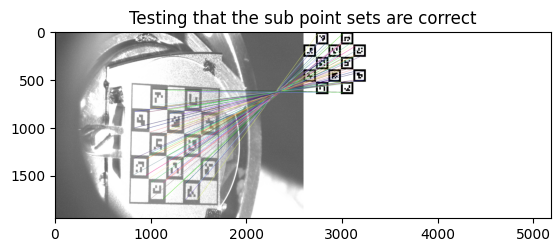

In [187]:
desired_img =  cv2.imread(directory+temp_board_filename)
source_img = cv2.imread(path)

check_img = show_matches(source_img, desired_img, sub_source_points, sub_desired_points)
plt.imshow(check_img)

plt.title("Testing that the sub point sets are correct")

## Now let's make a homography and test it



In [188]:
confidence = 0.9999
#https://docs.opencv.org/3.4/d9/d0c/group__calib3d.html#ga4abc2ece9fab9398f2e560d53c8c9780
H, _ = cv2.findHomography(np.array(sub_source_points),np.array(sub_desired_points), method = cv2.RANSAC,ransacReprojThreshold = 2,maxIters = 4000, confidence=confidence)
print(f" H= {H}, with confidence {confidence}")

 H= [[-7.05329127e-01 -1.25457711e-02  1.21203934e+03]
 [ 1.27467034e-02 -5.17660420e-01  9.07588096e+02]
 [-3.06366941e-05  6.84378739e-09  1.00000000e+00]], with confidence 0.9999


Text(0.5, 1.0, 'Testing that the Homography is correct')

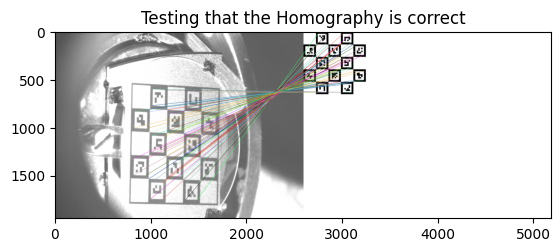

In [189]:
desired_img =  cv2.imread(directory+temp_board_filename)
source_img = cv2.imread(path)

check_img = show_homography(source_img, desired_img, sub_source_points, H)
plt.imshow(check_img)

plt.title("Testing that the Homography is correct")

## Now perform the homography between the source and desired image



Text(0, 0.5, 'mm')

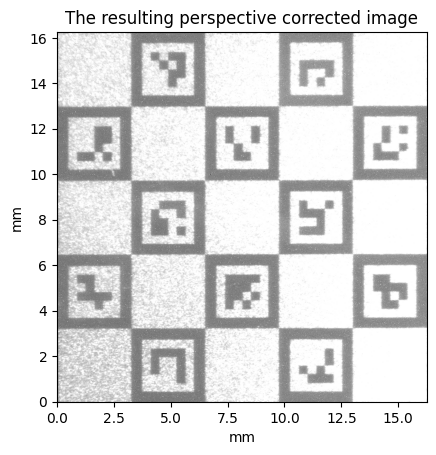

In [190]:
desired_img =  cv2.imread(directory+temp_board_filename)
source_img = cv2.imread(path)
warp_img = cv2.warpPerspective(source_img, H, (desired_img.shape[1], desired_img.shape[0]),flags=cv2.INTER_LINEAR) #https://theailearner.com/tag/cv2-getperspectivetransform/
plt.imshow(warp_img,extent=[0,board_size_mm,0,board_size_mm])

plt.title("The resulting perspective corrected image")
plt.xlabel("mm")
plt.ylabel("mm")

<Figure size 3840x2880 with 0 Axes>

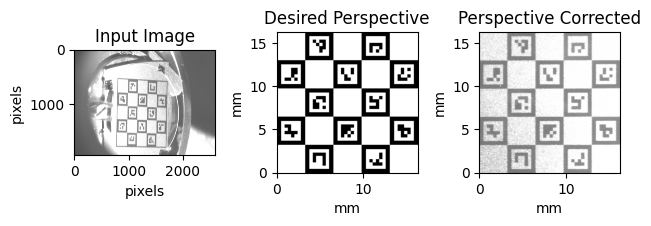

In [191]:
## For completeness, let's show them side by side


plt.figure(figsize=(8, 6),dpi=480)
f, axarr = plt.subplots(1,3) 
axarr[0].imshow(source_img)
axarr[0].set_xlabel("pixels")
axarr[0].set_ylabel("pixels")
axarr[0].set_title("Input Image")

axarr[1].imshow(desired_img,extent=[0,board_size_mm,0,board_size_mm])
axarr[1].set_xlabel("mm")
axarr[1].set_ylabel("mm")
axarr[1].set_title("Desired Perspective")


axarr[2].imshow(warp_img,extent=[0,board_size_mm,0,board_size_mm])
axarr[2].set_xlabel("mm")
axarr[2].set_ylabel("mm")
axarr[2].set_title("Perspective Corrected")

f.tight_layout()



